In [53]:
libraries = c("dplyr", "tidyverse", "magrittr", "ggpubr", "rworldmap", "MASS", "Rlab", "surveillance", "lubridate")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

options(scipen=10000)
theme_set(theme_bw())
version$version.string

[1] "R version 4.2.2 (2022-10-31)"

In [54]:
time_0 <- as.Date("2022-04-17") ## the date of symptom onset of the initial case in the UK
time_start <- as.Date("2022-04-01") ## the start date for the 14-days moving average
time_end <- as.Date("2022-10-02") ## the end date of study period

In [55]:
## mpox incidence data (the WHO data)
path <- "../data/incidence/WHO_dashboard/"
list.files(path = path, pattern = "*csv") -> file_list
read_csv_files <- function(x){return(suppressMessages(read.csv(paste0(path, x))))}
lapply(file_list, read_csv_files) -> df_list

do.call(rbind, df_list) %>% as.data.frame() %>% dplyr::select(-c("who_region", "who_region_long")) %>% 
rename(date=reference_date, iso_code=iso3, new_cases=cases, location=country) -> df_inci
df_inci$date <- as.Date(df_inci$date)

## modifying China data (manually distinguishing between mainland China, Taiwan, and Hong Kong)
df_inci %<>% mutate(iso_code=case_when(iso_code==c("CHN") & date < as.Date("2022-08-29") ~ c("TWN"),
                                       iso_code==c("CHN") & date == as.Date("2022-09-28") ~ c("TWN"),
                                       iso_code==c("CHN") & date == as.Date("2022-08-30") ~ c("HKG"),
                                       TRUE ~ iso_code),
                    location=case_when(iso_code==c("TWN") ~ c("Taiwan, Province of China"), 
                                       iso_code==c("HKG") ~ c("Hong Kong"), TRUE ~ location))

## adding missing countries with the manually collected Global.health data (by the date of repoting)
read.csv("../data/incidence/df_inci_Github.csv") -> df_global
df_global %>% filter(iso_code %in% c("ZAF", "PRY", "PRI", "MOZ", "MNE", "MTQ", "LBR", "JOR", "IRN", "GUM",
                                     "GLP", "BHR", "BEN", "BOL", "GHA", "CMR", "COG", "EGY", "GBZ", 
                                     "IND", "RUS", "MCO")) %>%
dplyr::select(Country, Date, Cases, iso_code) %>% mutate(date_type=c("Reported")) %>%
rename(location=Country, date=Date, new_cases=Cases) -> df_global
df_global$date <- as.Date(df_global$date, format="%Y-%m-%d")
rbind(df_inci, df_global) -> df_inci

## removing cases before the 2022 global mpox outbreak
df_inci %<>% filter(!(location==c("Singapore") & date <= as.Date("2022-05-01"))) %>%
filter(!(location==c("Brazil") & date <= as.Date("2022-05-01"))) %>%
filter(!(location==c("Czechia") & date <= as.Date("2022-05-01"))) %>%
group_by(location) %>% filter(date < time_end)

In [56]:
## estimating the mean value of the WHO reporting delay: zero-inflated lognoraml distribution
read.csv("../data/incidence/delay_WHO.csv") -> df_delay
df_delay %>% filter(reporting_delay >=0) -> df_delay_pos
rep(df_delay_pos$reporting_delay, df_delay_pos$cases) -> value_pos

dzip <- function (x, meanlog, sdlog, sigma){
    ifelse((x == 0), (pbern(1, sigma, log=FALSE)-pbern(0, sigma, log=FALSE)),
           dbern(0, sigma, log=FALSE)*(plnorm(x, meanlog, sdlog, log=FALSE)-plnorm((x-1), meanlog, sdlog, log=FALSE)))
}
fit_zip = fitdistr(value_pos, dzip, start = list(meanlog = 1.7, sdlog=0.5, sigma = 0.3), lower = list(p = 0.00001))

est_mean <- exp(as.numeric(fit_zip[[1]][1]) + (1/2)*as.numeric(fit_zip[[1]][2])^2)
est_median <- exp(as.numeric(fit_zip[[1]][1]))
est_sd <- exp(as.numeric(fit_zip[[1]][1]) + (1/2)*as.numeric(fit_zip[[1]][2])^2)*sqrt(exp(as.numeric(fit_zip[[1]][2])^2) - 1)

In [57]:
## backprojecting the first cases
df_inci %>% arrange(date) %>% group_by(location) %>% filter(rank(date)==1) %>% ungroup() -> df_first 

df_first %>% filter(!(date_type==c("Onset"))) %>%
filter(!(iso_code %in% c("CMR","LBR","CAF","NGA","COD","COG","GHA","GLP"))) -> df_first_report
as.data.frame(seq(as.Date("2021-12-01"), max(df_first$date), by=c("day"))) -> temp_cal
colnames(temp_cal) <- c("date")

unique(df_first_report$location) -> backproj_country
backproj_list <- list()

for (i in 1:length(backproj_country)){
    df_first_report %>% filter(location==backproj_country[i]) %>% dplyr::select(iso_code) %>% 
    unique() %>% as.character() -> iso_info
    merge(temp_cal, df_first_report %>% filter(location==backproj_country[i]), 
          by=c("date"), all.x=TRUE) -> df_backproj
    
    ## adding extra 10 days for the stability of back-projection
    as.data.frame(seq((max(df_first$date)+1), (max(df_first$date)+10), by=c("day"))) -> temp_lastdays
    colnames(temp_lastdays) <- c("date")
    temp_lastdays %<>% mutate(location=NA, iso_code=NA, date_type=c("Reported"), new_cases=0)
    rbind(df_backproj, temp_lastdays) %>% 
    mutate(location=backproj_country[i], iso_code=iso_info, date_type=c("Reported"),
           new_cases=case_when(is.na(new_cases)~0, TRUE~new_cases)) -> df_backproj
    df_backproj %<>% mutate(t = 1:nrow(df_backproj)) 
    
    ## the estimated time delay from the symptom onset to reporting
    K = nrow(df_backproj)
    report_probability = plnorm(1:K, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2])) - 
                         plnorm(1:K-1, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2]))
    report_pmf = c(0,report_probability[1:21])

    ## back-projecton of domestic cases
    sts = new("sts", epoch=df_backproj$t, observed=df_backproj$new_cases)
    bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), Tmark = nrow(sts), B = -1, 
                        alpha = 0.01, verbose = FALSE, lambda0 = NULL, eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_backproj$total_backproj = upperbound(sts_bp)

    ## normalizing the back-projected cases
    df_backproj$total_backproj[df_backproj$total_backproj<=0.01] <- 0

    df_backproj %>% mutate(total_normal = total_backproj/sum(total_backproj)*sum(new_cases)) %>%
    dplyr::select(-c("new_cases","total_backproj", "t")) %>% rename(new_cases=total_normal) %>% 
    mutate(date_type=c("Onset")) -> backproj_list[[i]]    
}

do.call(rbind, backproj_list) -> backproj_final

## merging the dataset with the back-projected cases
df_first %>% filter(date_type==c("Onset")) -> temp_onset
rbind(temp_onset, backproj_final) %>%
group_by(location, date, iso_code) %>% summarise(total_new_cases=sum(new_cases)) %>% 
ungroup() %>% rename(new_cases=total_new_cases) %>% filter(new_cases > 0) -> df_first_backproj

`summarise()` has grouped output by 'location', 'date'. You can override using
the `.groups` argument.


In [58]:
## the importation date of the first case
df_first_backproj %>% filter(date >= as.Date("2022-04-15")) %>% 
mutate(weight=case_when(new_cases >=1 ~ 1, 
                        iso_code %in% c("ISL") ~ new_cases/2,
                        iso_code %in% c("BEN") ~ new_cases/3, TRUE~new_cases)) -> df_first_imported_all

## data for only imputed symptom onset date
df_first_imported_all %>% filter(weight < 1) -> df_first_imputed
       
## Error bars for the back-projected first cases
df_first_imported_all %>% filter(weight < 1) %>% group_by(location) %>% mutate(cumul_dist=cumsum(weight)) %>%  
filter(abs(cumul_dist - 0.5) == min(abs(cumul_dist - 0.5))) %>% rename(import_med=date) %>% ungroup() %>%
dplyr::select(iso_code, import_med) -> weight_med

df_first_imported_all %>% filter(weight < 1) %>% group_by(location) %>% mutate(cumul_dist=cumsum(weight)) %>%  
filter(cumul_dist > 0.025) %>% filter(abs(cumul_dist - 0.025) == min(abs(cumul_dist - 0.025))) %>% 
rename(import_low=date) %>% ungroup() %>% dplyr::select(iso_code, import_low) -> weight_low

df_first_imported_all %>% filter(weight < 1) %>% group_by(location) %>% mutate(cumul_dist=cumsum(weight)) %>%  
filter(abs(cumul_dist - 0.975) == min(abs(cumul_dist - 0.975))) %>% rename(import_upp=date) %>% ungroup() %>%
dplyr::select(iso_code, import_upp) -> weight_upp

df_list <- list(weight_med, weight_low, weight_upp)
Reduce(function(x, y) merge(x, y, by=c("iso_code"), all=TRUE), df_list) -> date_interval
       
merge(df_first_imported_all, date_interval, by=c("iso_code"), all=TRUE) %>% 
mutate(import_med=case_when(weight==1 ~ date, TRUE ~ import_med)) %>%
dplyr::select(iso_code, location, import_med, import_low, import_upp) %>% distinct() -> df_first_imported

In [59]:
## backprojecting all cases
df_inci %>% filter(date_type %in% c("Diagnosis", "Reported")) %>% ungroup() -> df_inci_report
as.data.frame(seq(as.Date("2021-12-01"), max(df_inci$date), by=c("day"))) -> temp_cal; colnames(temp_cal) <- c("date")

unique(df_inci_report$location) -> backproj_country
backproj_list <- list()
for (i in 1:length(backproj_country)){
    df_inci_report %>% filter(location==backproj_country[i]) %>% dplyr::select(iso_code) %>% 
     unique() %>% as.character() -> iso_info
     merge(temp_cal, df_inci_report %>% filter(location==backproj_country[i]), 
           by=c("date"), all.x=TRUE) -> df_backproj
    
    ## adding extra 10 days for the stability of back-projection procedure
    as.data.frame(seq((max(df_inci$date)+1), (max(df_inci$date)+10), by=c("day"))) -> temp_lastdays
    colnames(temp_lastdays) <- c("date")
    temp_lastdays %<>% mutate(location=NA, iso_code=NA, date_type=c("Reported"), new_cases=0)
    rbind(df_backproj, temp_lastdays) %>% 
    mutate(location=backproj_country[i], iso_code=iso_info, date_type=c("Reported"),
           new_cases=case_when(is.na(new_cases)~0, TRUE~new_cases)) -> df_backproj
    df_backproj %<>% mutate(t = 1:nrow(df_backproj)) 
    
    
    ## the estimated time delay from the symptom onset to reporting
    K = nrow(df_backproj)
    report_probability = plnorm(1:K, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2])) - 
                         plnorm(1:K-1, meanlog=as.numeric(fit_zip[[1]][1]), sdlog=as.numeric(fit_zip[[1]][2]))
    report_pmf = c(0,report_probability[1:21])

    
    ## back-projecton of domestic cases
    sts = new("sts", epoch=df_backproj$t, observed=df_backproj$new_cases)
    bpnp.control = list(k = 2, eps = rep(1e-4,2), iter.max=rep(1000,2), 
                        Tmark = nrow(sts), B = -1, alpha = 0.01, verbose = FALSE, lambda0 = NULL, 
                        eq3a.method = c("R","C"))
    sts_bp = backprojNP(sts, incu.pmf=report_pmf, control=modifyList(bpnp.control,list(eq3a.method="C")))
    df_backproj$total_backproj = upperbound(sts_bp)


    ## normalizing the back-projected cases
    df_backproj$total_backproj[df_backproj$total_backproj<=0.01] <- 0

    df_backproj %>% mutate(total_normal = total_backproj/sum(total_backproj)*sum(new_cases)) %>%
    dplyr::select(-c("new_cases","total_backproj", "t")) %>% rename(new_cases=total_normal) %>% 
    mutate(date_type=c("Onset")) -> backproj_list[[i]]    
}

do.call(rbind, backproj_list) -> backproj_final

## merging the dataset with the back-projected cases
df_inci %>% filter(date_type==c("Onset")) -> temp_onset
rbind(temp_onset, backproj_final) %>%
group_by(location, date, iso_code) %>% summarise(total_new_cases=sum(new_cases)) %>% 
ungroup() %>% rename(new_cases=total_new_cases) %>% filter(new_cases > 0) -> df_inci

## date of the first importation
merge(df_inci, df_first_imported, by=c("location", "iso_code"), all=TRUE) %>% arrange(location, date) %>%
filter(!(iso_code %in% c("CMR","LBR","CAF","NGA","COD","COG","GHA","GLP"))) %>% 
rename(date_import=import_med) -> df_inci

`summarise()` has grouped output by 'location', 'date'. You can override using
the `.groups` argument.


In [60]:
## adding dates with zero case and calculating the cumulative number of cases
as.data.frame(seq(time_start, time_end, by="day")) -> temp_cal; colnames(temp_cal) <- c("date") 
unique(df_inci$location) -> MPX_country_list
df_inci$date <- as.Date(df_inci$date); temp_cal$date <- as.Date(temp_cal$date); 

df_inci_list <- list()
for(i in 1:length(MPX_country_list)){
    df_inci %>% filter(location==MPX_country_list[i]) -> temp_inci
    merge(temp_cal, temp_inci, by=c("date"), all.x=TRUE) -> temp_inci_all

    temp_inci_all$location[is.na(temp_inci_all$location)] <- unique(temp_inci$location)
    temp_inci_all$iso_code[is.na(temp_inci_all$iso_code)] <- unique(temp_inci$iso_code)
    temp_inci_all$new_cases[is.na(temp_inci_all$new_cases)] <- 0
    temp_inci_all$date_import[is.na(temp_inci_all$date_import)] <- unique(temp_inci$date_import)
    temp_inci_all$import_low[is.na(temp_inci_all$import_low)] <- unique(temp_inci$import_low)
    temp_inci_all$import_upp[is.na(temp_inci_all$import_upp)] <- unique(temp_inci$import_upp)
    
    temp_inci_all %>% dplyr::select(location, iso_code, date, new_cases, date_import, import_low, import_upp) %>%
    group_by(location) %>% mutate(total_cases=cumsum(new_cases)) -> df_inci_list[[i]]    
}

do.call("rbind", df_inci_list) %>% as.data.frame() %>% arrange(location, date) -> df_inci

In [61]:
## MSM population size data
read.csv("../data/MSM_pop/df_MSM_UNAIDS.csv") -> df_MSM1
read.csv("../data/MSM_pop/df_full_list_MSMsize_Fumi.csv") -> df_MSM2

read.csv("../data/MSM_pop/df_pop_raw.csv") %>% dplyr::select(cca2, pop2022) %>% rename(iso_2=cca2) -> df_pop1
read.csv("../data/MSM_pop/df_region.csv") %>% dplyr::select(alpha.2,alpha.3, name) %>%
rename(iso_2=alpha.2, iso_code=alpha.3, location=name) -> df_pop2
merge(df_pop1, df_pop2, by=c("iso_2")) -> df_pop
merge(df_MSM2 %>% dplyr::select(-pop2022), 
      df_pop %>% dplyr::select(iso_code, pop2022), by=c("iso_code"), all.x=TRUE) -> df_MSM2

## giving a priority to UNAIDS dashboard
merge(df_MSM1 %>% filter(!location==c("India")), df_MSM2, by=c("location"), all=TRUE) %>% 
dplyr::select(location, iso_code, estimate, MSM_size, region, sub_region, pop2022, MSM_percent) %>%
mutate(imputed=case_when(!is.na(estimate) ~ estimate, is.na(estimate) & !is.na(MSM_size) ~ MSM_percent*0.01*pop2022), 
       prop=imputed/pop2022*100) -> temp

## imputation of missing values
df_MSM2 %>% filter(!is.na(MSM_percent)) %>% dplyr::select(sub_region, MSM_percent) %>% 
rename(prop_med=MSM_percent) %>% distinct() -> prop_med 
temp %>% filter(sub_region %in% c("Northern America","Northern Europe","Southern Europe","Western Europe")) %>% 
group_by(sub_region) %>% drop_na(imputed) %>% summarise(prop_med = median(prop)) -> prop_med2
rbind(prop_med, prop_med2) -> prop_med_all

merge(temp, prop_med_all, by=c("sub_region"), all.x=TRUE) %>% drop_na(pop2022) %>%
mutate(prop=case_when(!is.na(prop)~prop, is.na(prop)~prop_med),
       imputed=case_when(!is.na(imputed)~imputed, is.na(imputed)~prop*0.01*pop2022)) -> df_MSM_imputed

## modifying Samoa data with the value from UNAIDS reports
df_MSM_imputed %>% mutate(imputed=case_when(location==c("Samoa")~MSM_size, TRUE~imputed),
                          prop=case_when(location==c("Samoa")~MSM_size/pop2022*100, TRUE~prop)) -> df_MSM_imputed

In [62]:
## merging incidence data with MSM population data
merge(df_inci, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) -> df_all_inci

merge(df_first_imputed, df_MSM_imputed %>% dplyr::select(iso_code, imputed, pop2022, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>%
mutate(region = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                          TRUE~region)) -> df_all_inci_imputed

In [63]:
## applying a 14-day moving average for the newly reported and cumulative case counts
df_all_inci %>% group_by(location) %>% arrange(date) %>%
mutate(MA_new_cases = zoo::rollmean(new_cases, k=14, align="right", fill=NA),
       MA_total_cases = zoo::rollmean(total_cases, k=14, align="right", fill=NA)) -> temp
temp$MA_new_cases[is.na(temp$MA_new_cases)]<-0; temp$MA_total_cases[is.na(temp$MA_total_cases)]<-0; 

temp %<>% mutate(MA_new_cases=case_when(MA_new_cases<0 ~ 0, TRUE ~ MA_new_cases),
                 MA_total_cases=case_when(MA_total_cases<0 ~ 0, TRUE ~ MA_total_cases))

## calculating the cumlative incidence proportion (i.e., cumulative incidecne/MSM population)
temp %>% rename(MSM_pop=imputed) %>% mutate(MSM_pop=MSM_pop*1000) %>% 
group_by(location) %>% mutate(cum_icni_prop=MA_total_cases/(MSM_pop)) %>%
dplyr::select(iso_code, location, region, sub_region, date, new_cases, total_cases, MA_new_cases, MA_total_cases,
              date_import, import_low, import_upp, MSM_pop, pop2022, cum_icni_prop) %>%
filter(date >= time_0) -> df_inci_MA

write.csv(df_inci_MA, "../data/df_inci_final_WHO_backproj.csv")

In [64]:
bimonthly <- function(x) {
  x_range <- range(x, na.rm = TRUE)
  date_range <- c(floor_date(x_range[1], "month"), ceiling_date(x_range[2], "month"))
  monthly <- seq(date_range[1], date_range[2], by = "1 month")
  sort(c(monthly, monthly + days(14)))
}

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


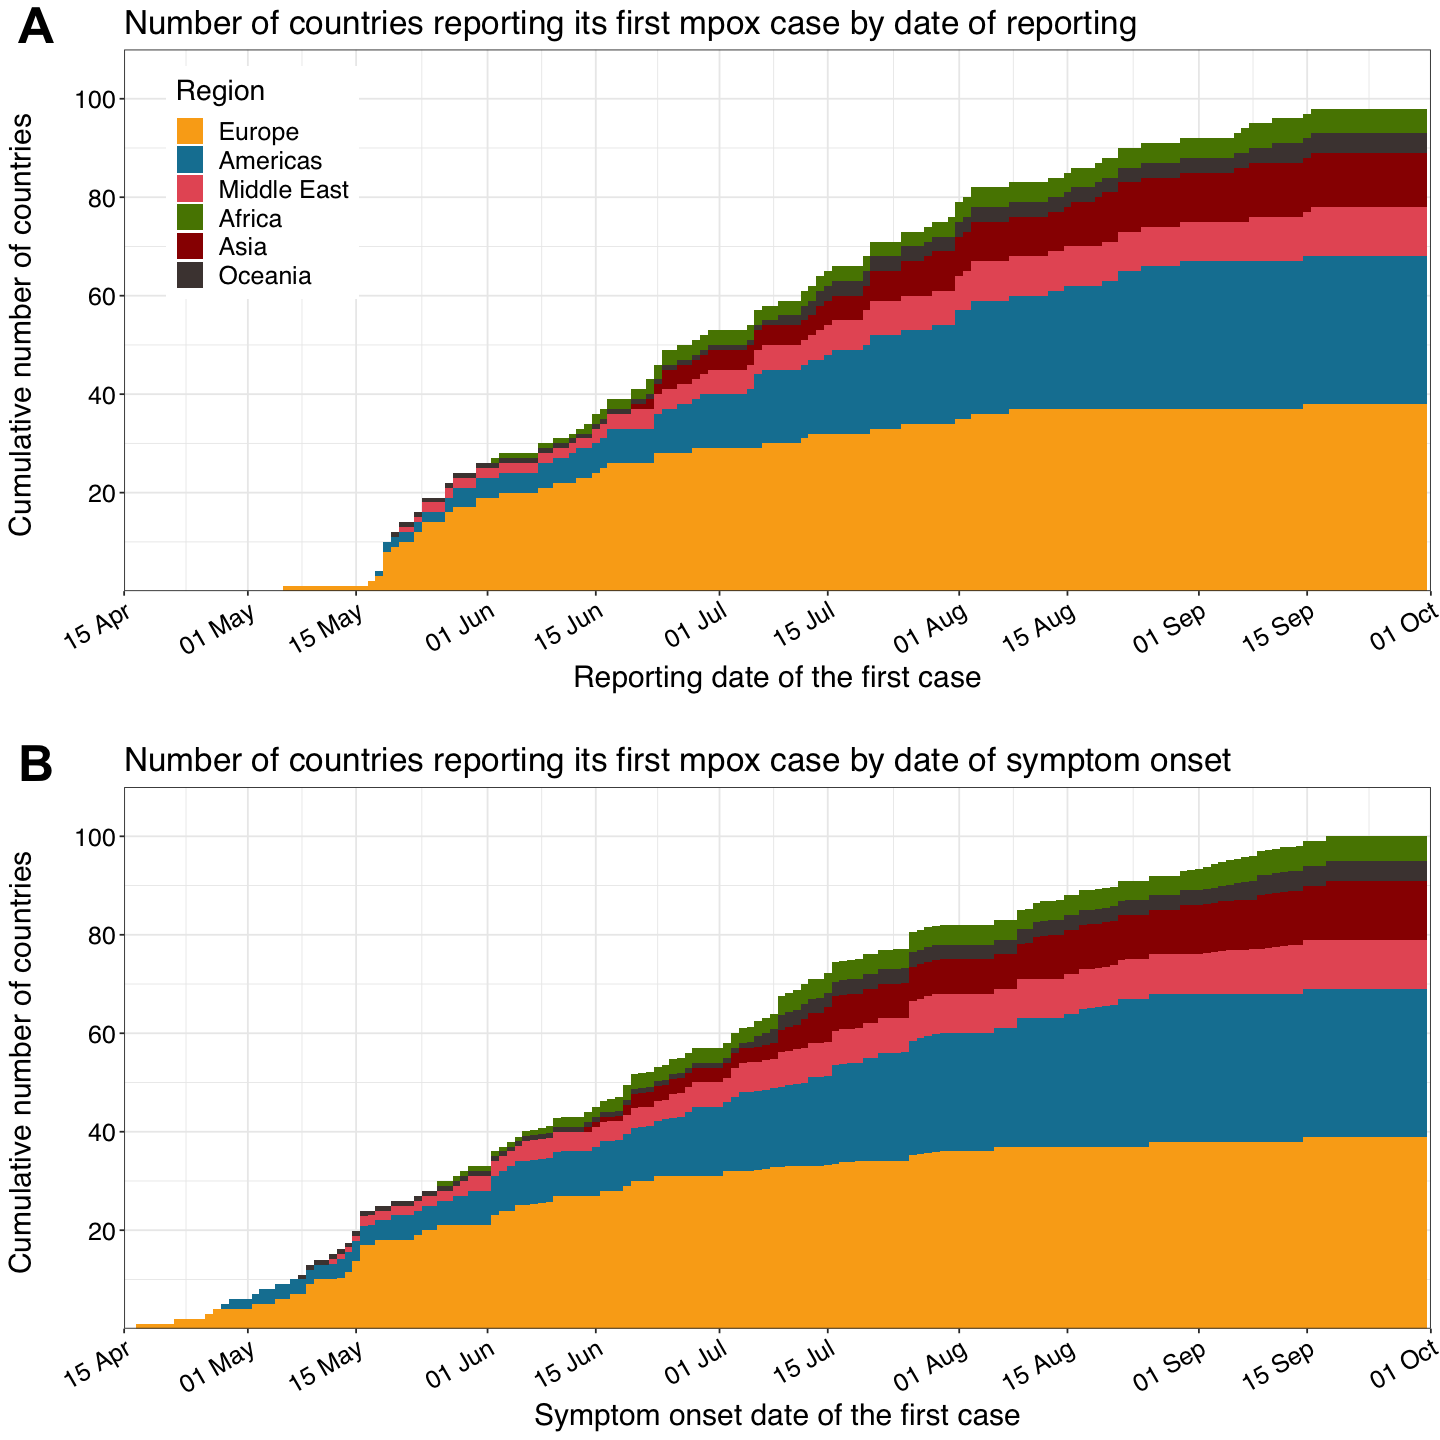

In [65]:
#### Figure 1
## with the reporting date
read.csv("../data/incidence/df_inci_Github.csv") %>% arrange(Country, Date) %>% 
mutate(date_import_adj=case_when(iso_code==c("CHN")~ as.Date("2022-06-24"), TRUE~as.Date(date_import))) %>%
dplyr::select(Country, iso_code, date_import_adj) %>% rename(date_import=date_import_adj) %>% 
distinct() -> df_reporting

df_inci_MA %>% ungroup() %>% 
mutate(region_adj = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region)) %>%
dplyr::select(region_adj, iso_code) %>% rename(region=region_adj) %>% distinct() -> temp

merge(df_reporting, temp, by=c("iso_code")) -> df_fig
as.Date(df_fig$date_import) -> df_fig$date_import
df_fig$region <- factor(df_fig$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

df_fig %>% filter(date_import >= as.Date("2022-04-15")) %>% dplyr::count(date_import, region) -> temp
as.data.frame(rep(seq(min(temp$date_import), max(temp$date_import), 1), each=6)) -> temp2
colnames(temp2) <- ("date_import")
temp2 %<>% mutate(region=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(temp$date_import), max(temp$date_import), 1))))
merge(temp2, temp, by=c("date_import", "region"), all.x=TRUE) -> df_fig_cum
df_fig_cum[is.na(df_fig_cum)] <-0
df_fig_cum %<>% group_by(region) %>% mutate(count=cumsum(n)) %>% ungroup() 

df_fig_cum %>% filter(date_import==max(df_fig_cum$date_import)) %>% mutate(n=0) -> temp
Reduce(rbind, list(temp)[rep(1, times=as.numeric(as.Date("2022-10-01")-max(df_fig_cum$date_import)))]) %>% 
as.data.frame() %>% 
mutate(date_import=rep(seq(max(df_fig_cum$date_import)+1, as.Date("2022-10-01"),1),each=6)) -> temp_empty
rbind(df_fig_cum, temp_empty) -> df_fig_cum

options(repr.plot.width=12,repr.plot.height=6)
ggplot(df_fig_cum, aes(x = date_import, y=count, fill = fct_reorder(region, count))) +
geom_bar(stat="identity", width=1) +
scale_fill_viridis_d(direction = 1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x=element_text(angle=30, hjust=1),
      legend.position = c(0.18, .97),
      legend.justification = c("right", "top"), legend.box.just = "left", legend.margin = margin(6, 6, 6, 6)) +
xlab("Reporting date of the first case") +
ylab("Cumulative number of countries \n") +
ggtitle("Number of countries reporting its first mpox case by date of reporting") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), as.Date("2022-10-01")), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20,40,60,80,100)) +
coord_cartesian(ylim = c(0,110)) -> Fig1


## with the symptom onset date
merge(df_first_backproj, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% filter(date >= as.Date("2022-04-15")) %>% 
mutate(region=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region),
       weight=case_when(new_cases >=1 ~ 1, 
                        iso_code %in% c("ISL") ~ new_cases/2,
                        iso_code %in% c("BEN") ~ new_cases/3,
                        TRUE~new_cases)) -> df_fig2

df_fig2$region <- factor(df_fig2$region, levels=c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"))

as.data.frame(rep(seq(min(df_fig2$date), max(df_fig2$date), 1), each=6)) -> temp2; colnames(temp2) <- ("date")
temp2 %<>% mutate(region=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(df_fig2$date), max(df_fig2$date), 1))))
merge(temp2, df_fig2, by=c("date", "region"), all.x=TRUE) -> df_fig_cum2
df_fig_cum2[is.na(df_fig_cum2)] <-0

df_fig_cum2 %<>% group_by(region) %>% mutate(count=cumsum(weight)) %>% ungroup() %>% 
group_by(region, date) %>% top_n(1, count) %>% dplyr::select(date, region, iso_code, count)

df_fig_cum2 %>% filter(date==max(df_fig_cum2$date)) %>% mutate(iso_code=c("0")) -> temp
Reduce(rbind, list(temp)[rep(1, times=as.numeric(as.Date("2022-10-01")-max(df_fig_cum2$date)))]) %>% 
as.data.frame() %>% 
mutate(date=rep(seq(max(df_fig_cum2$date)+1, as.Date("2022-10-01"),1),each=6)) -> temp_empty
rbind(df_fig_cum2, temp_empty) -> df_fig_cum2

df_fig_cum2 %<>% mutate(order=case_when(region==c("Europe")~6, region==c("Americas")~5, region==c("Middle East")~4,
                                        region==c("Asia")~3, region==c("Oceania")~2, region==c("Africa")~1))

options(repr.plot.width=12,repr.plot.height=6, warn=-1)
ggplot(df_fig_cum2, aes(x = date, y=count, fill = fct_reorder(region, order))) +
geom_bar(stat="identity", width=1) +
scale_fill_viridis_d(direction = 1) +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=20, family="sans",color="black"),
      axis.title = element_text(size=18, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      legend.position="none",
      axis.text.x=element_text(angle=30, hjust=1)) +
xlab("Symptom onset date of the first case") +
ylab("Cumulative number of countries \n") +
ggtitle("Number of countries reporting its first mpox case by date of symptom onset") +
scale_x_date(date_labels = "%d %b", breaks=bimonthly,
             limits=c(as.Date("2022-04-15"), as.Date("2022-10-01")), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(20,40,60,80,100)) +
coord_cartesian(ylim = c(0,110)) -> Fig2

options(repr.plot.width=12,repr.plot.height=12)
ggarrange(Fig1, ggplot() + theme_void(), Fig2, ncol = 1, heights = c(1, 0.05, 1), 
          labels = c("A", "", "B"), font.label = list(size = 30), vjust=1.2)

In [66]:
## mpox first arrival time by the date of symptom onset (with interval)
merge(df_first_imported, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
by=c("iso_code"), all.x=TRUE) %>% filter(import_med >= as.Date("2022-04-15")) %>% 
mutate(region=case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), TRUE~region),
       location=case_when(location==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                          location==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                          location==c("South Korea")~c("Korea, Republic of"),
                          location==c("Türkiye")~c("Turkey"),
                          location==c("The United Kingdom") ~ c("United Kingdom"),
                          location==c("Republic of Moldova")~c("Moldova, Republic of"), 
                          location==c("Iran")~c("Iran, Islamic Republic of"),
                          location==c("Réunion")~c("Reunion"),
                          location==c("Venezuela")~c("Venezuela, Bolivarian Republic of"),
                          location==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                          location==c("Bolivia")~c("Bolivia, Plurinational State of"),
                          location==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                          location==c("Curaçao")~c("Curacao"),
                          location==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                          location==c("Czech Republic")~c("Czechia"),
                          location==c("Moldova")~c("Moldova, Republic of"),
                          location==c("Bosnia And Herzegovina")~c("Bosnia and Herzegovina"),
                          location==c("Russia")~c("Russian Federation"),
                          location==c("United States")~c("United States of America"), 
                          TRUE~location)) -> df_mpox_arrival_interval

In [67]:
## mpox first arrival time by the date of reporting
read.csv("../data/incidence/Github.csv") -> df_mpox
df_mpox$Date <- as.Date(df_mpox$Date)

df_mpox %>% filter(Cumulative_cases > 0) %>% group_by(Country) %>% arrange(Date) %>% slice(1L) %>% ungroup() %>% 
filter(Date >= as.Date("2022-05-01")) %>%
filter(!Country %in% c("Ghana", "Liberia", "Congo", "Nigeria", "Cameroon", 
                       "Democratic Republic Of The Congo", "Central African Republic")) %>%
mutate(Country=case_when(Country==c("Hong Kong")~c("China"),
                         Country==c("Taiwan")~c("China"),
                         TRUE~Country))  %>%
group_by(Country) %>% arrange(Date) %>% slice(1L) %>% ungroup() -> df_mpox_arrival


read.csv("../data/incidence/df_inci_Github.csv") -> df_mpox_iso
df_mpox_iso %<>% dplyr::select(Country, iso_code) %>% distinct()

merge(df_mpox_arrival, df_mpox_iso, by=c("Country"), all.x=TRUE) -> df_mpox_arrival

merge(df_mpox_arrival, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("South Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         Country==c("Czech Republic")~c("Czechia"),
                         Country==c("Moldova")~c("Moldova, Republic of"),
                         Country==c("Bosnia And Herzegovina")~c("Bosnia and Herzegovina"),
                         Country==c("Russia")~c("Russian Federation"),
                         Country==c("United States")~c("United States of America"),
                         TRUE~Country)) %>% rename(Date_reported = Date) -> df_mpox_arrival


df_mpox %>% filter(Date >= as.Date("2022-05-01")) %>%
filter(!Country %in% c("Ghana", "Liberia", "Republic of Congo", "Nigeria", "Cameroon", 
                       "Democratic Republic Of The Congo", "Central African Republic")) %>%
mutate(Country=case_when(Country==c("Hong Kong")~c("China"),
                         Country==c("Taiwan")~c("China"),
                         TRUE~Country)) -> df_mpox_case

merge(df_mpox_case, df_mpox_iso, by=c("Country"), all.x=TRUE) -> df_mpox_case

merge(df_mpox_case, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>% rename(Date_reported = Date) -> df_mpox_case

In [68]:
df_mpox_case %<>% arrange(Country)

cal <- as.data.frame(rep(seq(min(df_mpox_case$Date_reported),max(df_mpox_case$Date_reported),1),
                         length(unique(df_mpox_case$Country))))
colnames(cal) <- c("Date_reported")
cal %<>% mutate(Country=rep(unique(df_mpox_case$Country),
                          each=length(seq(min(df_mpox_case$Date_reported),max(df_mpox_case$Date_reported),1))))

merge(df_mpox_case %>% dplyr::select(Country, group), cal, by=c("Country")) %>% distinct() -> cal
merge(df_mpox_case %>% dplyr::select(-group), cal, by=c("Date_reported", "Country"), all.y=TRUE) %>%
dplyr::select(Date_reported, Country, Cases, group) -> df_mpox_case

df_mpox_case$Cases[is.na(df_mpox_case$Cases)] <- 0
df_mpox_case %>% group_by(Date_reported, group) %>% summarize(total_case=sum(Cases)) %>% ungroup() %>%
group_by(group) %>% mutate(cum_case=cumsum(total_case)) -> df_mpox_case

`summarise()` has grouped output by 'Date_reported'. You can override using the
`.groups` argument.


In [69]:
## covid first arrival time by the date of reporting
library(MazamaSpatialUtils)

## WHO data
read.csv("../data/Covid/WHO-COVID-19-global-data.csv") -> df_covid
df_covid$Date_reported <- as.Date(df_covid$Date_reported)
df_covid %>% filter(Cumulative_cases > 0) %>% group_by(Country) %>% arrange(Date_reported) %>% slice(1L) %>% 
ungroup() -> df_covid_raw

## corrected data
read.csv("../data/Covid/Supplementary_Material_2.csv") %>%
filter(Correction==c("Wrong")) %>% dplyr::select(Country_code, Country, Correct.date) -> df_covid_corrected
merge(df_covid_raw, df_covid_corrected, by=c("Country_code", "Country"), all.x=TRUE) -> df_covid_corrected
df_covid_corrected$Correct.date <- as.Date(df_covid_corrected$Correct.date)

## combined one
df_covid_corrected %<>% mutate(Date_reported=case_when(!is.na(Correct.date) ~ Correct.date, TRUE~Date_reported)) %>%
dplyr::select(-Correct.date) %>% filter(!(Country==c("Other"))) %>%
mutate(diff=log(as.numeric(Date_reported-min(df_covid_corrected$Date_reported))), 
       iso_code=iso2ToIso3(Country_code)) -> df_covid_arrival

merge(df_covid_arrival, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("Republic of Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran (Islamic Republic of)")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela (Bolivarian Republic of)")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia (Plurinational State of)")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         TRUE~Country)) -> df_covid_arrival


df_covid %>% filter(!(Country==c("Other"))) %>%
filter(Date_reported <= min(df_covid$Date_reported)+134) %>%
mutate(iso_code=iso2ToIso3(Country_code)) -> df_covid_case

merge(df_covid_case, df_MSM_imputed %>% dplyr::select(iso_code, region, sub_region), 
      by=c("iso_code"), all.x=TRUE) %>% na.omit() %>% 
mutate(group = case_when(sub_region %in% c("Central Asia", "Western Asia") ~ c("Middle East"), 
                         TRUE~region)) %>%
mutate(Country=case_when(Country==c("Côte d’Ivoire")~c("Cote d'Ivoire"),
                         Country==c("Democratic Republic of the Congo")~c("Congo, Democratic Republic of the"),
                         Country==c("Republic of Korea")~c("Korea, Republic of"),
                         Country==c("Türkiye")~c("Turkey"),
                         Country==c("The United Kingdom") ~ c("United Kingdom"),
                         Country==c("Republic of Moldova")~c("Moldova, Republic of"), 
                         Country==c("Iran (Islamic Republic of)")~c("Iran, Islamic Republic of"),
                         Country==c("Réunion")~c("Reunion"),
                         Country==c("Venezuela (Bolivarian Republic of)")~c("Venezuela, Bolivarian Republic of"),
                         Country==c("occupied Palestinian territory, including east Jerusalem")~c("Palestine, State of"),
                         Country==c("Bolivia (Plurinational State of)")~c("Bolivia, Plurinational State of"),
                         Country==c("Northern Mariana Islands (Commonwealth of the)") ~ c("Northern Mariana Islands"),
                         Country==c("Curaçao")~c("Curacao"),
                         Country==c("Micronesia (Federated States of)")~c("Micronesia, Federated States of"),
                         TRUE~Country)) -> df_covid_case

In [70]:
df_covid_case %<>% arrange(Country)

cal <- as.data.frame(rep(seq(min(df_covid_case$Date_reported),max(df_covid_case$Date_reported),1),
                         length(unique(df_covid_case$Country))))
colnames(cal) <- c("Date_reported")
cal %<>% mutate(Country=rep(unique(df_covid_case$Country),
                          each=length(seq(min(df_covid_case$Date_reported),max(df_covid_case$Date_reported),1))))

merge(df_covid_case, cal, by=c("Date_reported", "Country"), all.y=TRUE) %>%
dplyr::select(Date_reported, Country, New_cases, group) -> df_covid_case

df_covid_case$New_cases[is.na(df_covid_case$New_cases)] <- 0
df_covid_case %>% group_by(Date_reported, group) %>% summarize(total_case=sum(New_cases)) %>% ungroup() %>%
group_by(group) %>% mutate(cum_case=cumsum(total_case)) -> df_covid_case

`summarise()` has grouped output by 'Date_reported'. You can override using the
`.groups` argument.


In [71]:
df_covid_arrival %>% filter(Date_reported <= min(df_covid_arrival$Date_reported)+134) -> df_covid_fig

setdiff(df_covid_fig$Country, df_mpox_arrival$Country) -> list_country; 
list_country <- list_country[1:(length(list_country)-1)]
df_covid_arrival %>% filter(Country %in% list_country) %>% 
dplyr::select(iso_code, Country, region, sub_region, group) %>% 
mutate(Date_reported=as.Date("2022-12-31"), Cases=0, Cumulative_cases=0) -> df_mpox_add

rbind(df_mpox_add, df_mpox_arrival) -> df_mpox_all

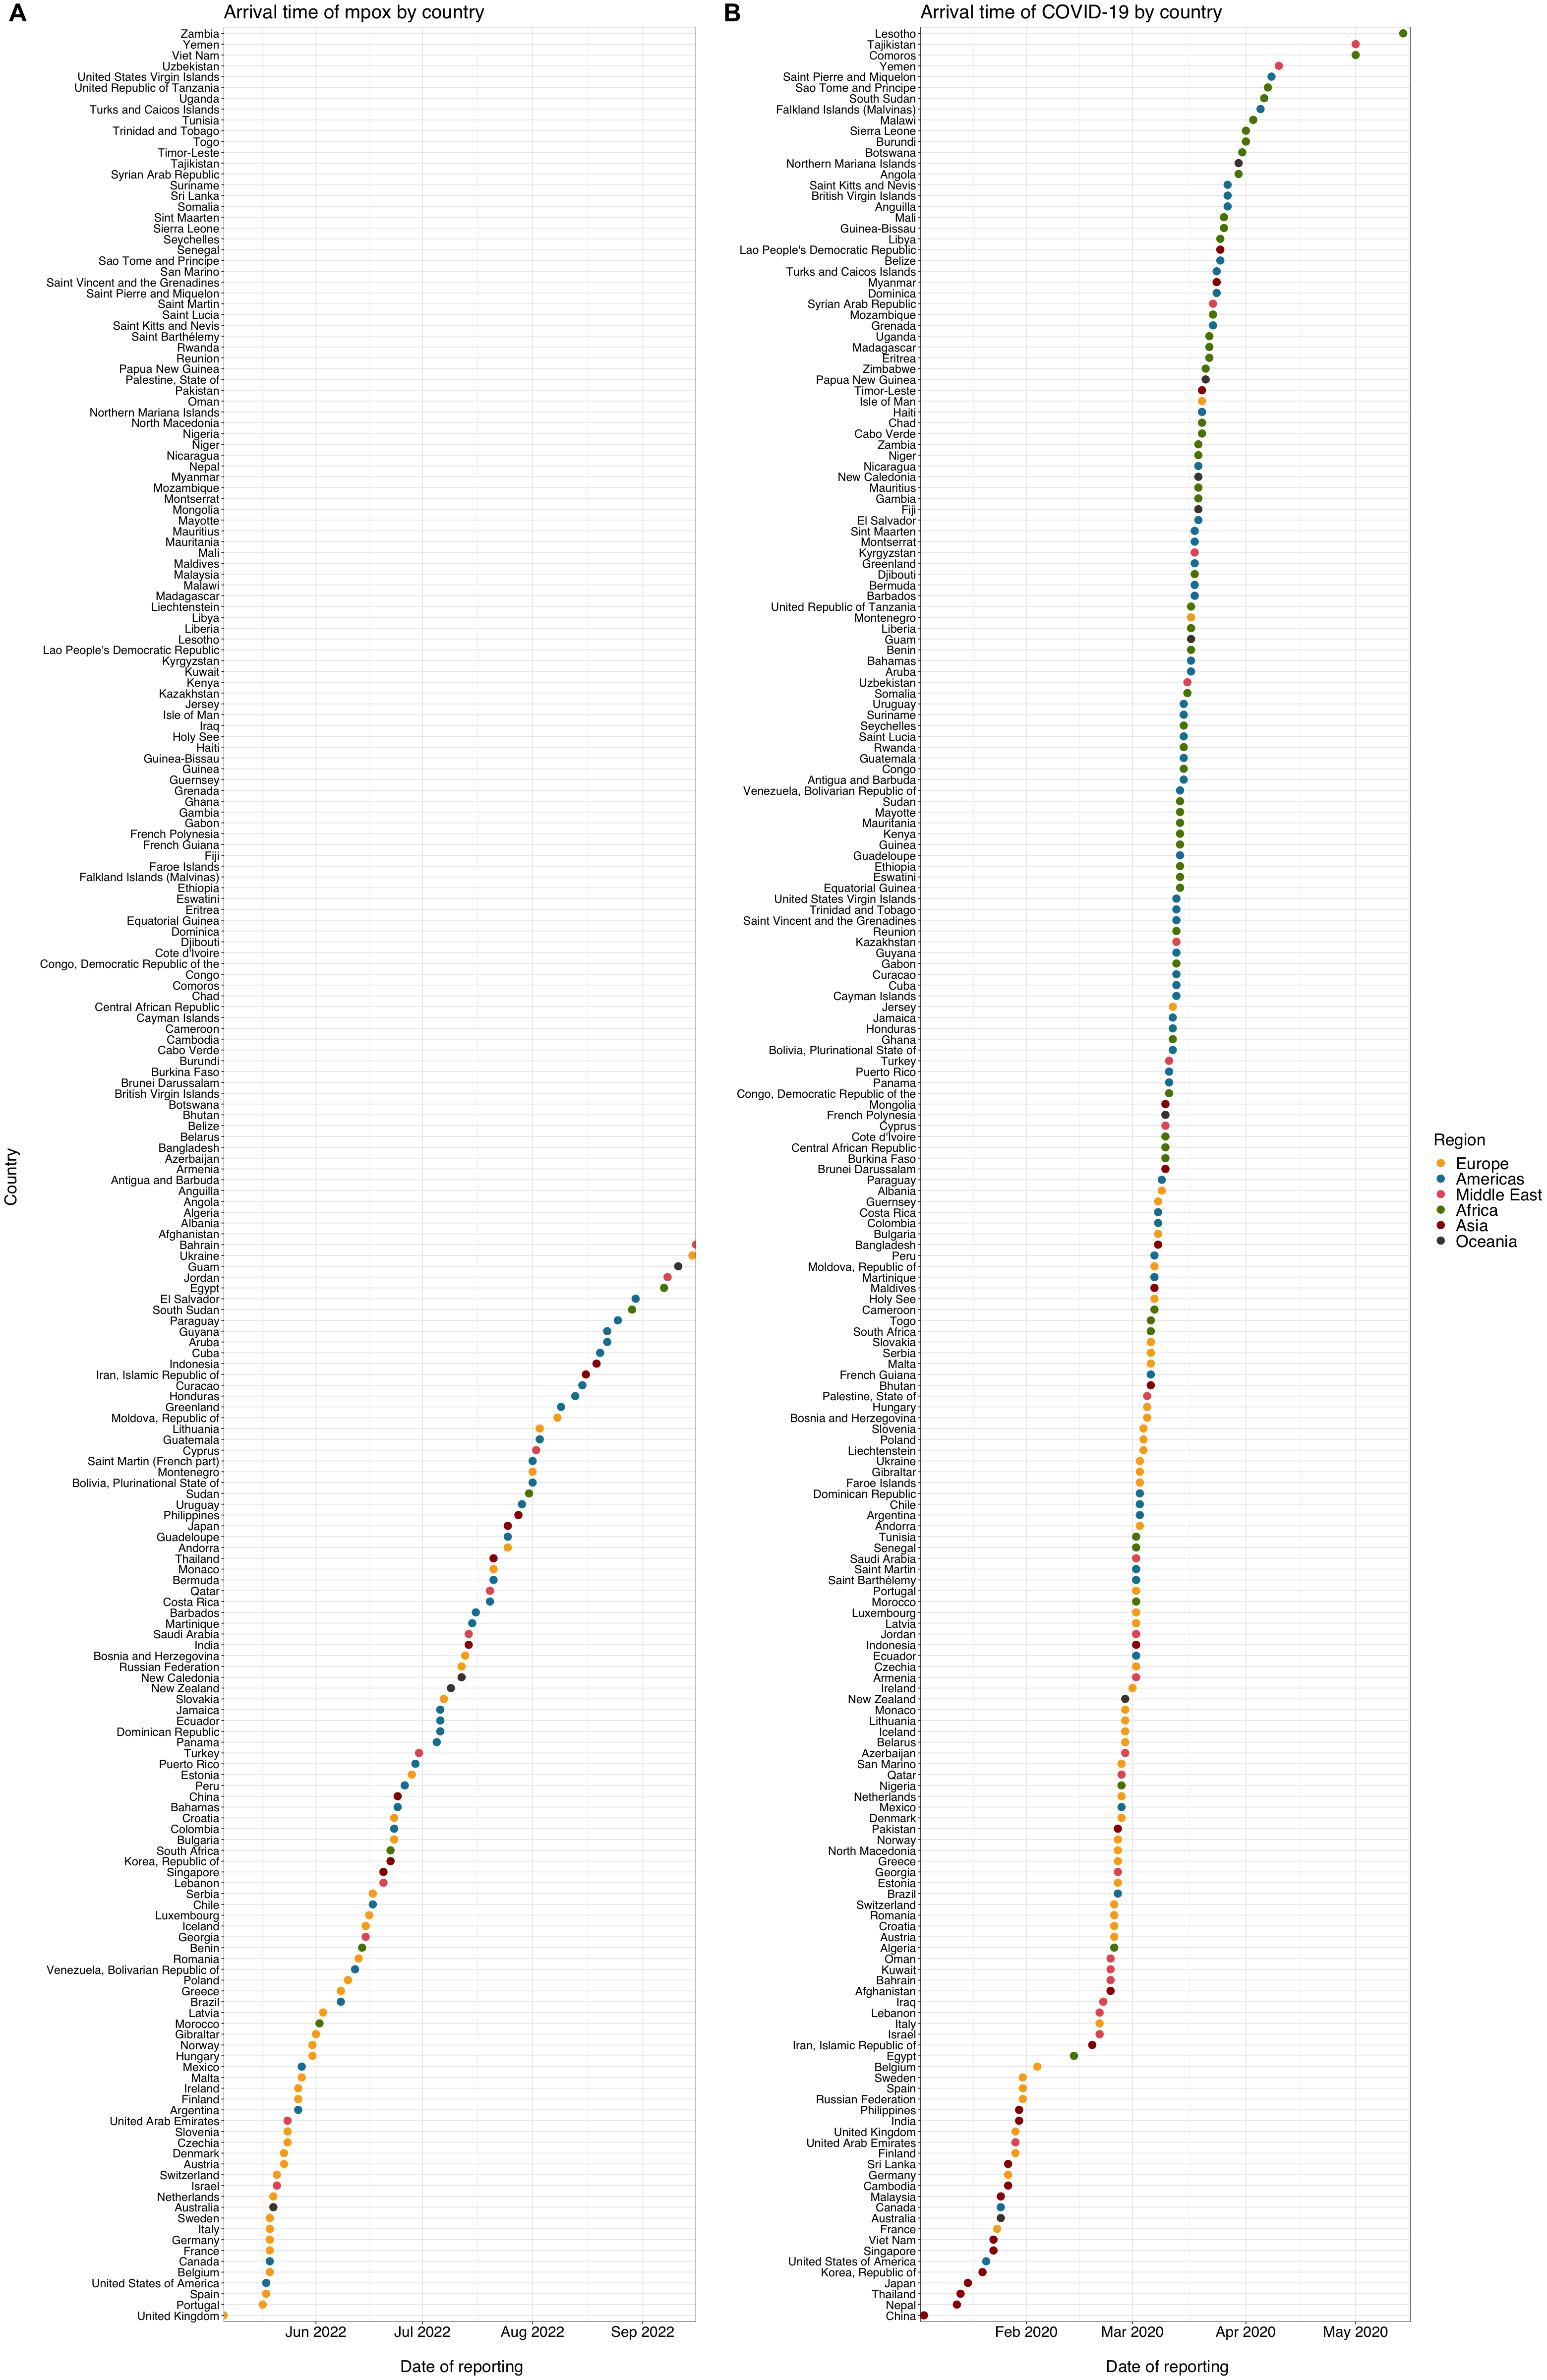

In [72]:
options(repr.plot.width=13,repr.plot.height=30)

ggplot() +
geom_point(data=df_covid_fig, 
           aes(x=reorder(Country,Date_reported), y=Date_reported, color=group), size=4) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="", y="\n Date of reporting") +
ggtitle("Arrival time of COVID-19 by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=14, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> covid_dateimp

ggplot() +
geom_point(data=df_mpox_all, 
           aes(x=reorder(Country,Date_reported), y=Date_reported, color=group), size=4) +
scale_color_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="Country \n", y="\n Date of reporting") +
ggtitle("Arrival time of mpox by country") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=14, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_y_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), max(df_mpox_arrival$Date_reported)), expand = c(0, 0)) +
coord_flip(xlim = NULL, ylim = NULL, expand = TRUE, clip = "on") -> mpox_dateimp

options(repr.plot.width=26,repr.plot.height=40)
ggarrange(mpox_dateimp, ggplot() + theme_void(), covid_dateimp, ggplot() + theme_void(), 
          ncol = 4, widths = c(1, 0.02, 1, 0.02),
          labels = c("A", "", "B", ""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")

In [73]:
df_covid_arrival %>% filter(Date_reported <= min(df_covid_arrival$Date_reported)+134) %>% 
dplyr::count(Date_reported, group) -> temp
as.data.frame(rep(seq(min(temp$Date_reported), max(temp$Date_reported), 1), each=6)) -> temp2
colnames(temp2) <- ("Date_reported")
temp2 %<>% mutate(group=rep(c("Africa", "Americas", "Asia", "Europe", "Middle East", "Oceania"), 
                             length(seq(min(temp$Date_reported), max(temp$Date_reported), 1))))
merge(temp2, temp, by=c("Date_reported", "group"), all.x=TRUE)  -> df_covid_country
df_covid_country[is.na(df_covid_country)] <-0
df_covid_country %<>% group_by(group) %>% mutate(count=cumsum(n)) %>% ungroup()


df_fig_cum %>% group_by(date_import) %>% summarize(global_count=sum(count)) %>% ungroup() -> df_fig_cum_log
df_covid_country %>% group_by(Date_reported) %>% summarize(global_count=sum(count)) %>% ungroup() -> df_covid_country_log

In [74]:
options(repr.plot.width=13,repr.plot.height=10)
ggplot(df_fig_cum, aes(x = date_import, y=count, fill = region)) +
geom_bar(stat="identity") +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
xlab("\n Date of reporting") +
ylab("Cumulative countries \n") +
ggtitle("Cumulative number of countries reporting its first mpox case") +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(50,100,150,200,250)) +
coord_cartesian(ylim = c(0,250)) -> mpox_country2

options(repr.plot.width=13,repr.plot.height=10)
ggplot(df_covid_country, aes(x = Date_reported, y=count, fill = group)) +
geom_bar(stat="identity") +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
xlab("\n Date of reporting") + ylab("") +
ggtitle("Cumulative number of countries reporting its first COVID-19 case") +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0), breaks=c(50,100,150,200,250)) +
coord_cartesian(ylim = c(0,250)) -> covid_country2

In [75]:
options(repr.plot.width=13,repr.plot.height=10)
limit_y=600000
limit_y2=600000

ggplot() +
geom_bar(data=df_covid_case, 
           aes(x=Date_reported, y=cum_case, fill=group), stat='identity') +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="\n Date of reporting", y="") +
ggtitle("Cumulative number of COVID-19 cases") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_covid$Date_reported), min(df_covid$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,limit_y2)) -> covid_case2

ggplot() +
geom_bar(data=df_mpox_case, 
           aes(x=Date_reported, y=cum_case, fill=group), stat='identity') +
scale_fill_manual("Region", limits=c("Europe", "Americas", "Middle East", "Africa", "Asia", "Oceania"),
                  values = c("#FAAB18", "#1380A1", "#E75B64FF", "#588300", "#990000", "#4C413FFF")) +
labs(x="\n Date of reporting", y="Cumulative cases \n ") +
ggtitle("Cumulative number of mpox cases") + 
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.title = element_text(size=20, family="sans",color="black"),
        axis.text.x = element_text(size=18, family="sans",color="black"),
        axis.text.y = element_text(size=18, family="sans",color="black"),
        legend.title = element_text(size = 20),
        legend.text = element_text(size = 20),
        plot.title = element_text(size=23, family="sans",color="black")) +
scale_x_date(date_labels = "%b %Y",
             limits=c(min(df_mpox_all$Date_reported), min(df_mpox_all$Date_reported)+134), expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,limit_y)) -> mpox_case2

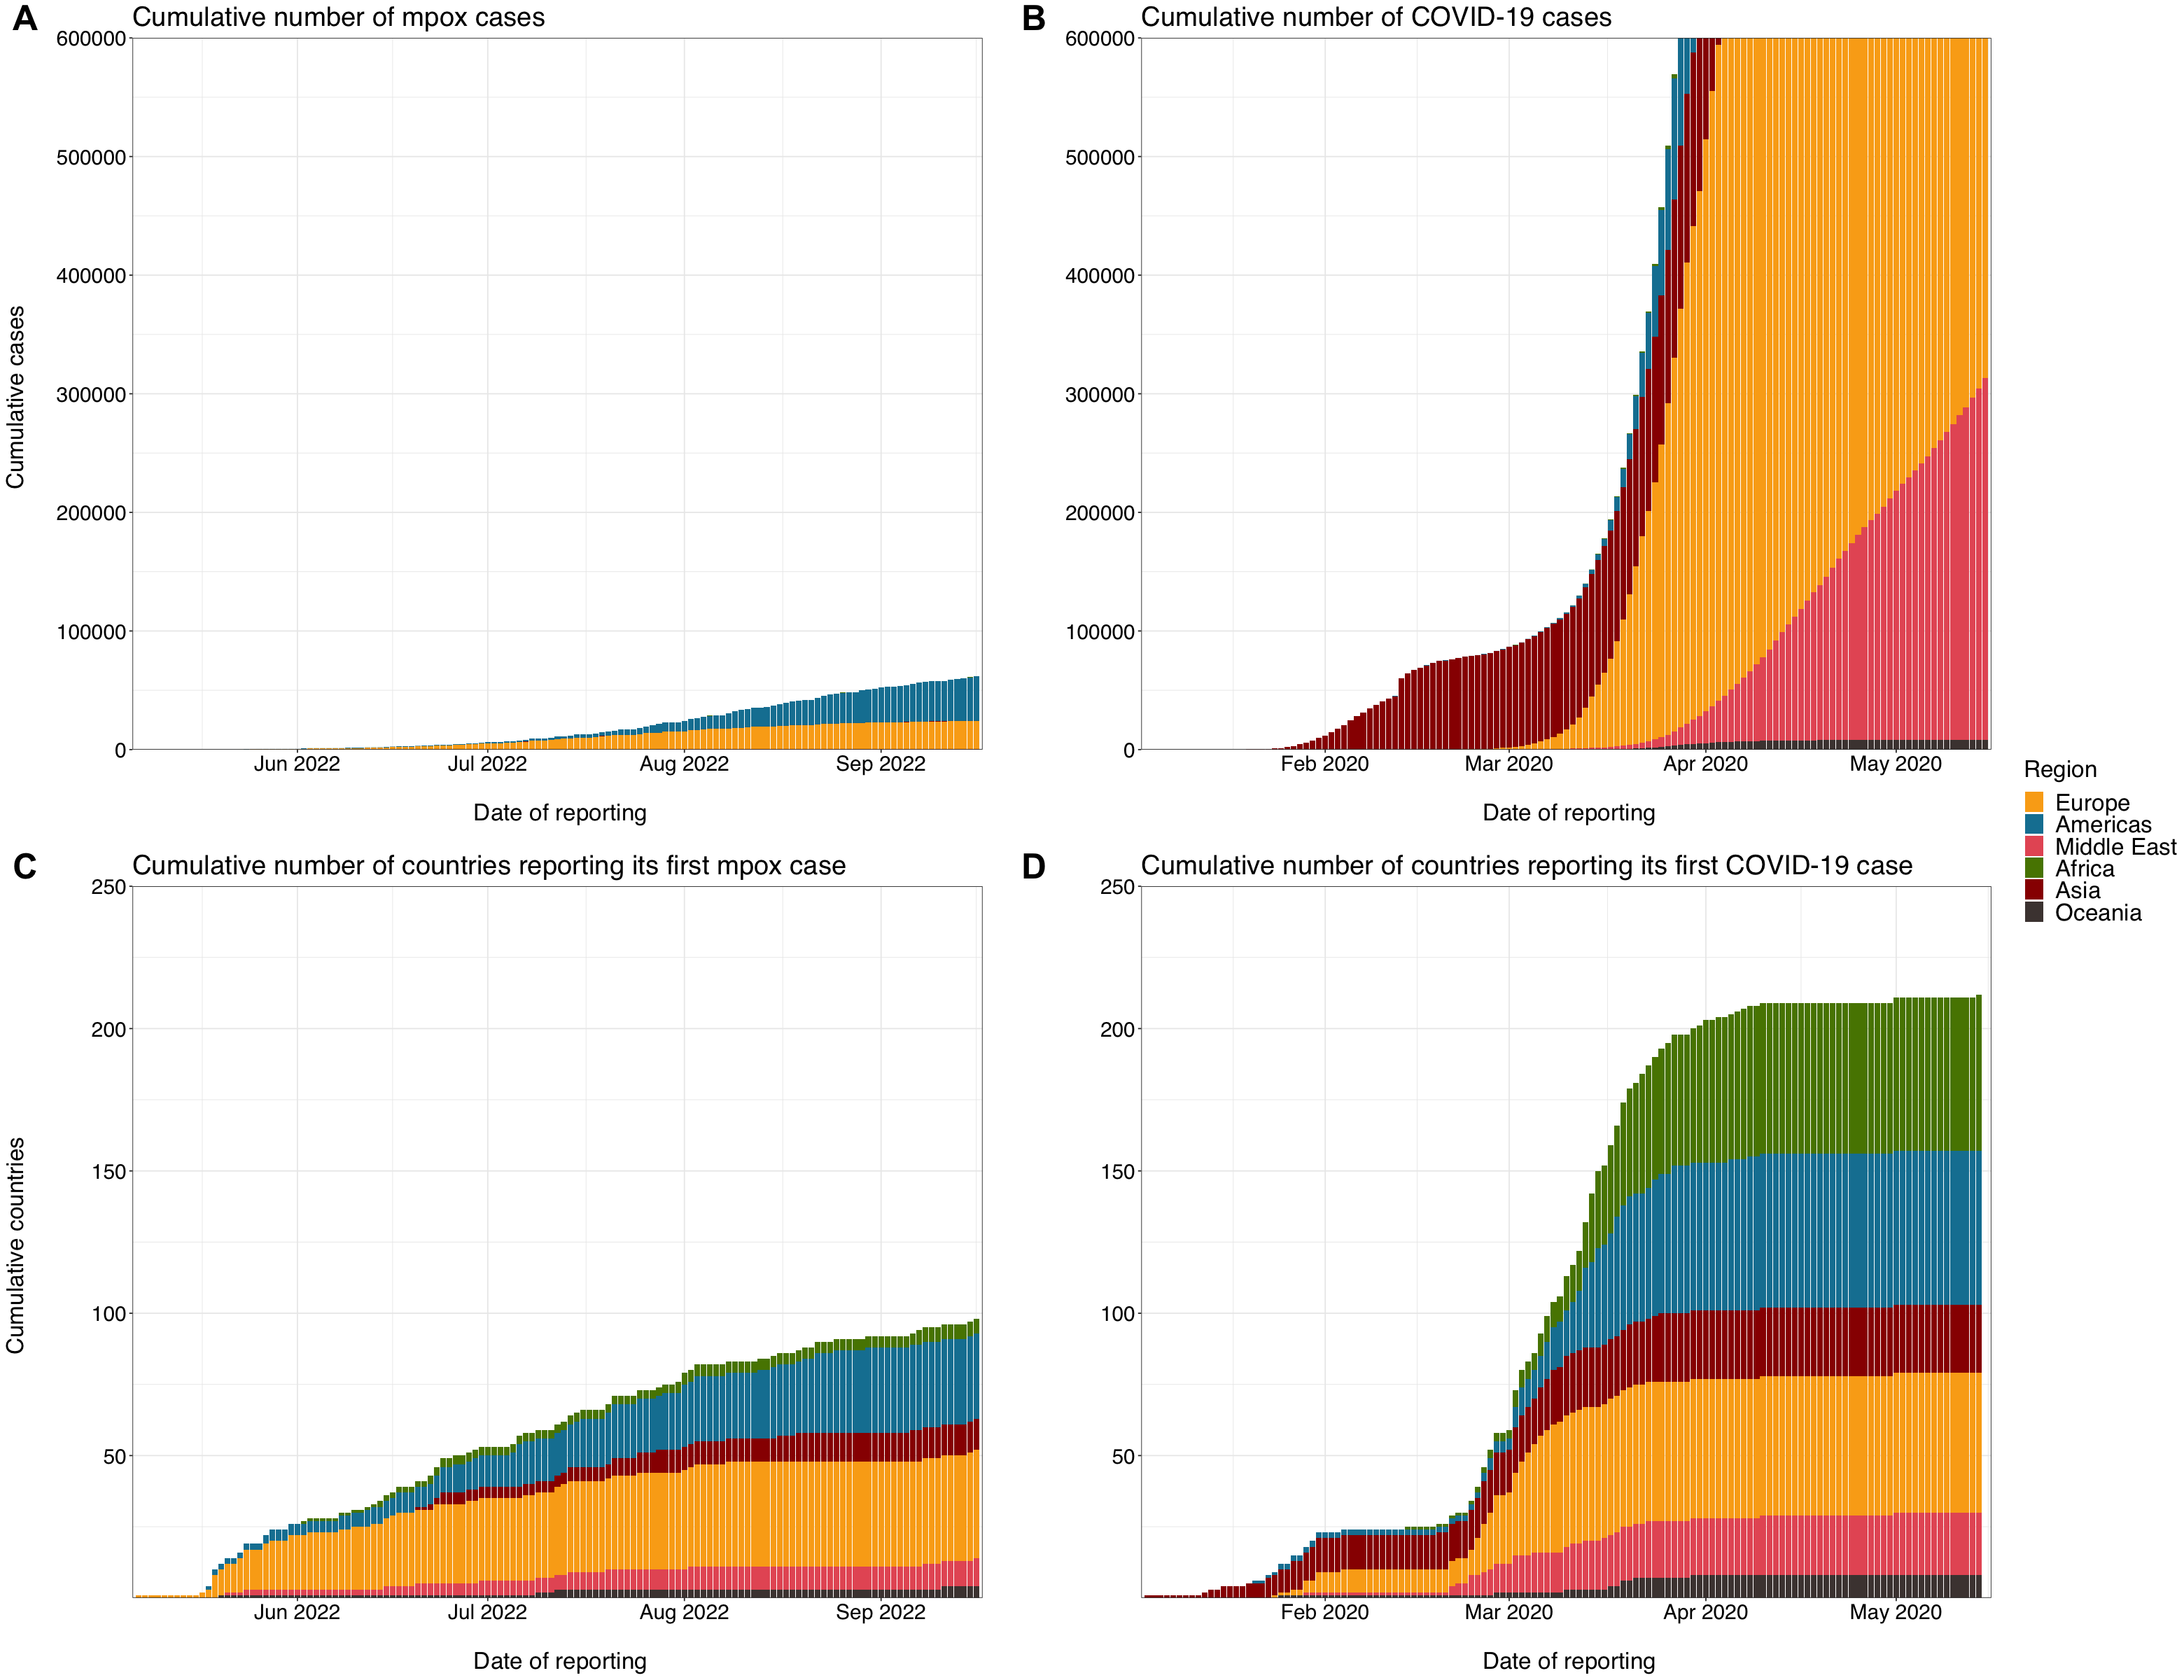

In [76]:
options(repr.plot.width=26,repr.plot.height=20)
ggarrange(mpox_case2, ggplot() + theme_void(), covid_case2, ggplot() + theme_void(), 
          ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(), ggplot() + theme_void(),
          mpox_country2, ggplot() + theme_void(), covid_country2, ggplot() + theme_void(), 
          ncol = 4, nrow = 3, heights = c(1, 0.02, 1), widths = c(1, 0.02, 1, 0.02), align = "v",
          labels = c("A","","B","","","","","","C","","D",""), font.label = list(size = 30), vjust=1.2,
          common.legend = TRUE, legend="right")